# Polar plot for one category, multiple experiments

## Get experiments in this category

In [1]:
import os
drive_path = '/media/stephen/Brain20191/allen-brain-observatory/visual-coding-2p/'
if not os.path.isdir(drive_path):
    drive_path = '/media/alihamodi/Brain2019/allen-brain-observatory/visual-coding-2p/'

In [8]:
targeted_structure = 'VISp'
# TODO: Change this to an array + add your stuff
imaging_depth = [550]
cre_line = 'Ntsr1-Cre_GN220'

In [9]:
import warnings; warnings.simplefilter('ignore')
from utils.polarplot import *
from utils.polardata import *
from utils.data_wrappers import *
import os
import pandas as pd
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as stim_info
from utils.data_wrappers import *
manifest_file = os.path.join(drive_path,'manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_file)

exps = boc.get_ophys_experiments(stimuli=[stim_info.DRIFTING_GRATINGS],
        targeted_structures = [targeted_structure],
        # TODO: add your imaging layers here
        imaging_depths = imaging_depth,
        cre_lines = [cre_line])
print ("There are", len(exps), "experiments")

There are 6 experiments


## Generate data

Processing experiment 665722301
In this experiment, we have 28 cells, but after filtering, we have 3 cells
Processing experiment 689388034
In this experiment, we have 214 cells, but after filtering, we have 39 cells
Processing experiment 604145810
In this experiment, we have 65 cells, but after filtering, we have 11 cells
Processing experiment 603576132
In this experiment, we have 163 cells, but after filtering, we have 41 cells
Processing experiment 645086975
In this experiment, we have 69 cells, but after filtering, we have 12 cells
Processing experiment 627823695
In this experiment, we have 34 cells, but after filtering, we have 10 cells


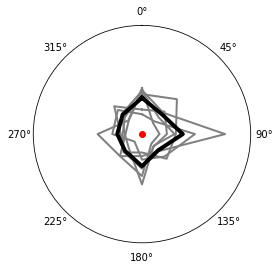

In [11]:
cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)

def get_avg_cell_polar_in_experiment(boc, ec_id, exp_id, cells):
    """
    Get the polar data for all cells in this experiment, then average them out to get a single polar data.
    """
    in_category_cells = cells[cells.experiment_container_id == ec_id]
    dg_response_filter = get_dg_response_filter_from_saskia()
    filtered_cells = get_filtered_cells(in_category_cells, dg_response_filter)
    # TODO: Add your filtering logic here
    
#     new_col = []
#     for index, row in filtered_cells.iterrows():
#         print(index, row)
#         polardata_for_this_cell = get_avg_normalized_response(
#             boc = boc,
#             session_id = exp_id,
#             cell_specimen_id = row.cell_specimen_id,
#             temporal_frequency = 2.0)
#         new_dsi_cell = get_new_dsi(polardata_for_this_cell.to_frame())
#         new_col.append(new_dsi_cell)
#     filtered_cells['new_dsi_cell'] = new_col
    filtered_cells = filtered_cells[filtered_cells.dsi_dg > 0.5]

    print ("In this experiment, we have", len(in_category_cells),
           "cells, but after filtering, we have", len(filtered_cells), "cells")
    
    thetas = []
    rs = []
    cell_ids = []
    for ii, row in filtered_cells.iterrows():
        cell_specimen_id = row.cell_specimen_id
        pref_tf = row.pref_tf
        one_cell_polar_data_dict = get_avg_normalized_response(
            boc=boc,
            session_id=exp_id,
            cell_specimen_id = cell_specimen_id,
            temporal_frequency=pref_tf)
        if one_cell_polar_data_dict is None:
            continue
        theta, r = convert_polar_dict_to_arrays(one_cell_polar_data_dict)
        thetas.append(theta)
        rs.append(r)
        cell_ids.append(cell_specimen_id)
    if len(thetas) == 0:
        return None, None
    agg_theta, agg_r = get_avg_polar(thetas, rs)
    return agg_theta, agg_r

thetas = []
rs = []
for exp in exps:
    e_id = exp['id']
    ec_id = exp['experiment_container_id']
    print("Processing experiment", e_id)
    theta, r = get_avg_cell_polar_in_experiment(boc, ec_id, e_id, cells)
    thetas.append(theta)
    rs.append(r)

if len(thetas) == 0:
    print("No good polar data, maybe all negative :(")
else:
    agg_theta, agg_r = get_avg_polar(thetas, rs)
    fig, axes = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(polar=True))
    polar_plot_population(ax=axes,
        bold_theta = agg_theta,
        bold_r = agg_r,
        grey_thetas = thetas, 
        grey_rs = rs)

## Plot em

### Final result

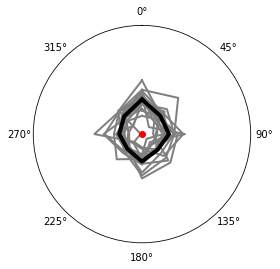

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(polar=True))
polar_plot_population(ax=axes,
    bold_theta = agg_theta,
    bold_r = agg_r,
    grey_thetas = thetas, 
    grey_rs = rs)

### Per experiment

exp id 502608215


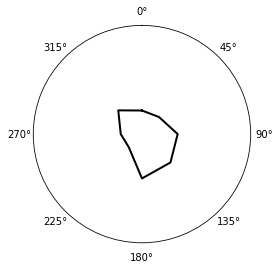

exp id 502608215


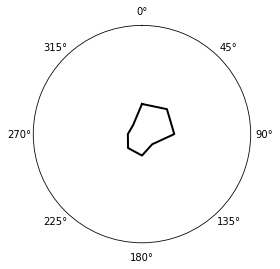

exp id 502608215


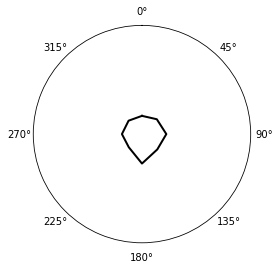

exp id 502608215


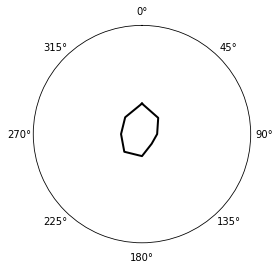

exp id 502608215


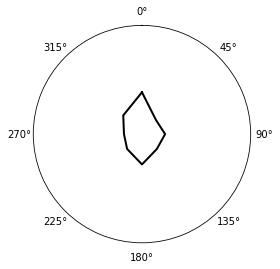

exp id 502608215


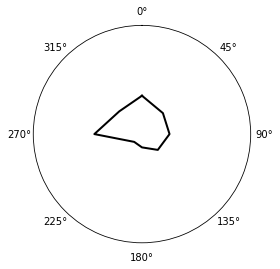

exp id 502608215


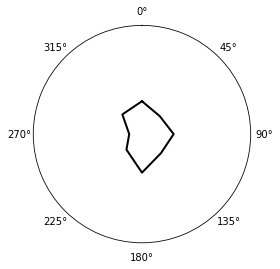

exp id 502608215


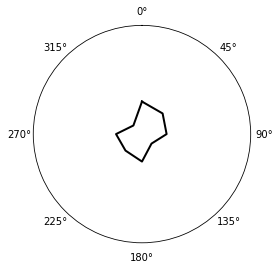

exp id 502608215


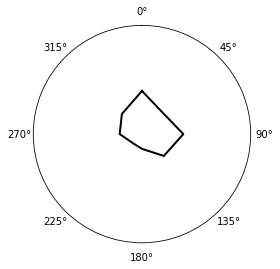

exp id 502608215


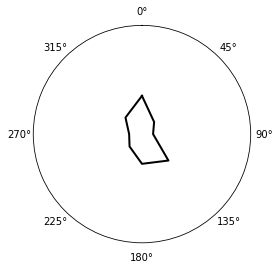

exp id 502608215


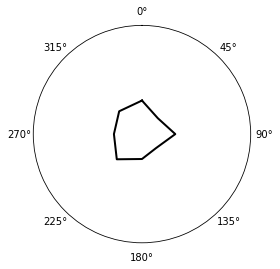

exp id 502608215


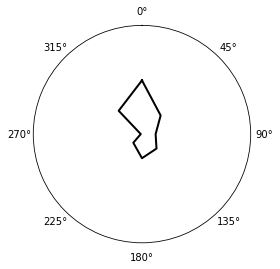

exp id 502608215


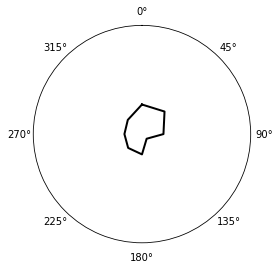

exp id 502608215


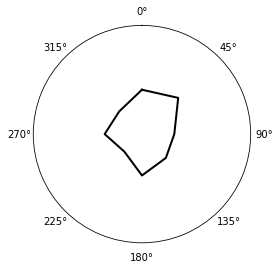

exp id 502608215


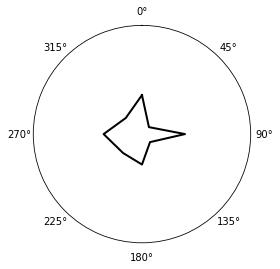

exp id 502608215


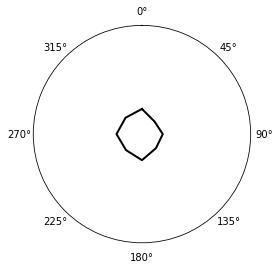

In [31]:
for i in range(len(exps)):
    e_id = exp['id']
    print ("exp id", e_id)
    fig, axes = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(polar=True))
    polar_plot(axes, thetas[i], rs[i])
    plt.show()

# Polar plot for all categories

In [53]:
get_one_category_polar_data_cache = {}

In [54]:
def get_one_category_polar_data(boc, targeted_structure, imaging_depth, cre_line):
    cache_key = (targeted_structure, imaging_depth, cre_line)
    if cache_key in get_one_category_polar_data_cache:
        return get_one_category_polar_data_cache[cache_key]
    
    exps = boc.get_ophys_experiments(stimuli=[stim_info.DRIFTING_GRATINGS],
        targeted_structures = [targeted_structure],
        imaging_depths = [imaging_depth],
        cre_lines = [cre_line])
    if len(exps) == 0:
        return None, None, None, None
    print ("There are", len(exps), "experiments for ", targeted_structure, imaging_depth, cre_line)
    
    thetas = []
    rs = []
    for exp in exps:
        e_id = exp['id']
        ec_id = exp['experiment_container_id']
        print("Processing experiment", e_id)
        theta, r = get_avg_cell_polar_in_experiment(boc, ec_id, e_id, cells)
        if theta is None or len(theta) == 0:
            continue
        thetas.append(theta)
        rs.append(r)
        
    agg_theta, agg_r = get_avg_polar(thetas, rs)
    
    if len(thetas) == 0:
        agg_theta, agg_r, thetas, rs= None, None, None, None
    
    get_one_category_polar_data_cache[cache_key] = (agg_theta, agg_r, thetas, rs)
    return get_one_category_polar_data_cache[cache_key]


In [55]:
get_one_category_polar_data(boc, 'VISp', 175, 'Pvalb-IRES-Cre')

There are 2 experiments for  VISp 175 Pvalb-IRES-Cre
Processing experiment 670395999
In this experiment, we have 3 cells, but after filtering, we have 0 cells
Processing experiment 671164733
In this experiment, we have 49 cells, but after filtering, we have 0 cells


(None, None, None, None)

There are 8 experiments for  VISp 175 Cux2-CreERT2
Processing experiment 704298735
In this experiment, we have 157 cells, but after filtering, we have 25 cells
Processing experiment 510514474
In this experiment, we have 402 cells, but after filtering, we have 34 cells
Processing experiment 501704220
In this experiment, we have 225 cells, but after filtering, we have 33 cells
Processing experiment 502205092
In this experiment, we have 396 cells, but after filtering, we have 66 cells
Processing experiment 501271265
In this experiment, we have 295 cells, but after filtering, we have 66 cells
Processing experiment 501836392
In this experiment, we have 243 cells, but after filtering, we have 37 cells
Processing experiment 510517131
In this experiment, we have 396 cells, but after filtering, we have 51 cells
Processing experiment 502115959
In this experiment, we have 305 cells, but after filtering, we have 44 cells


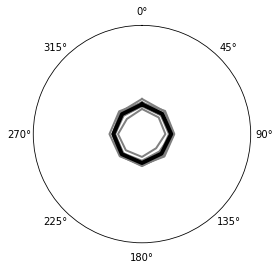

In [56]:
agg_theta, agg_r, thetas, rs = get_one_category_polar_data(boc, 'VISp', 175, 'Cux2-CreERT2')
fig, axes = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(polar=True))
polar_plot_population(ax=axes,
    bold_theta = agg_theta,
    bold_r = agg_r,
    grey_thetas = thetas, 
    grey_rs = rs)

setting depth PolarAxesSubplot(0.125,0.749828;0.352273x0.130172) 175
setting depth PolarAxesSubplot(0.125,0.593621;0.352273x0.130172) 265
setting depth PolarAxesSubplot(0.125,0.437414;0.352273x0.130172) 275
setting depth PolarAxesSubplot(0.125,0.281207;0.352273x0.130172) 300
setting depth PolarAxesSubplot(0.125,0.125;0.352273x0.130172) 325


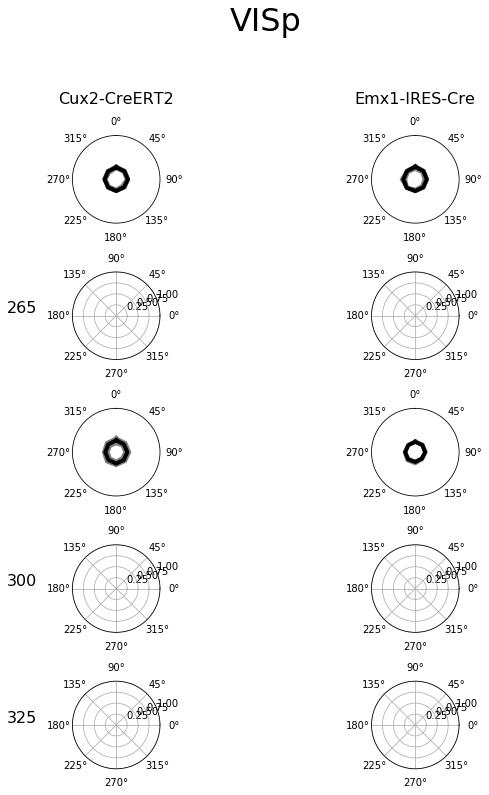

In [67]:
def plot_one_brain_area_chart(boc, targeted_structure, imaging_depths, cre_lines):
    """
    - brain_area (string): e.g. 'V1'
    - layers (string[]): Order of layers, where each row = 1 layer. E.g. 'L2/3'
    - cre_lines {string[]}: Order of columns, where each column = 1 celltype. E.g. 'SST'
    """
    fig, axes = plt.subplots(
        nrows=len(imaging_depths),
        ncols=len(cre_lines),
        figsize=(10,10),
        subplot_kw=dict(polar=True))
    fig.suptitle(targeted_structure, fontsize=32, y = 1.1)
    
    for ax, cre_line in zip(axes[0], cre_lines):
        ax.set_title(cre_line, fontsize=16, y = 1.3)

    for ax, imaging_depth in zip(axes[:,0], imaging_depths):
        print ("setting depth", ax, imaging_depth)
        ax.set_ylabel(str(imaging_depth), rotation=0, fontsize=16, labelpad = 50)
    
    for ax in axes.flatten():
        ax.axis('on')
    
    for imaging_depth in imaging_depths:
        for cre_line in cre_lines:
            agg_theta, agg_r, thetas, rs = get_one_category_polar_data(
                boc,
                targeted_structure,
                imaging_depth,
                cre_line)
            if agg_theta is None:
                continue
            # Get the axis given layer and celltype, then plot
            imaging_depth_id = imaging_depths.index(imaging_depth)
            cre_line_id = cre_lines.index(cre_line)
            ax = axes[imaging_depth_id, cre_line_id]
            ax.axis('on')
            polar_plot_population(ax=ax,
                bold_theta = agg_theta,
                bold_r = agg_r,
                grey_thetas = thetas, 
                grey_rs = rs)
    fig.tight_layout()
    
#plot_one_brain_area_chart(boc, 'VISp', boc.get_all_imaging_depths(), boc.get_all_cre_lines())
plot_one_brain_area_chart(boc, 'VISp', [175, 265, 275, 300, 325], ['Cux2-CreERT2', 'Emx1-IRES-Cre'])